In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import driftrate

cmap = 'gray'
def getCHIMEBurst(plot=False):
    maxsnr_beam = 2067
#     data = np.load("data/chime/aro_detection.npz")
    data = np.load("data/chime/chimefrb_SGR1935+2154_20200428_B{}.npz".format(maxsnr_beam))
    #print(data.files)
    intensity = data["intensity"]
    intensity = np.nan_to_num(intensity)
    
    #corr = driftrate.auto_corr2D_viafft(intensity[:,50:90])
    if plot:
        plt.figure(figsize=(15,9))
        plt.imshow(intensity[:, 40:], aspect="auto", origin="lower", cmap=cmap)
        plt.clim(-0.15, 0.1)
        print(np.min(intensity), np.max(intensity))
    
    # CHIME
    burst1 = intensity[:, 50:90]
    burst2 = intensity[:, 90:]
    
    # ARO
#     burst1 = intensity[:, 40:70]
#     burst2 = intensity[:, 71:90]
    
    return [burst1, burst2]

def getKirstenBursts(plot=False):
    kirstenb1 = np.load('data/franz/kirsten_et_al_NatAst_2020/burst_plot/B1_downsampled.npy')
    kirstenb2 = np.load('data/franz/kirsten_et_al_NatAst_2020/burst_plot/B2_downsampled.npy')

    # noise
    for chan in [191, 127, 63]:
        kirstenb1[chan:chan+1] = 0
        kirstenb2[chan:chan+1] = 0

    if plot:
        for burst in [kirstenb1, kirstenb2]:
            plt.figure(figsize=(8,15))
            plt.imshow(burst, aspect="auto", origin="lower", cmap=cmap)
            plt.clim(-1,1)

    return [kirstenb1, kirstenb2]

AROParameters = {
    'dt_s'            : 0.00098304,
    'df_mhz'          : 400/256,
    'nchan'           : 1024,
    'freq_bottom_mhz' : 400.1953125,
    'freq_top_mhz'    : 800.1953125
}

CHIMEParameters = {
    'dt_s'            : 0.00098304,
    'df_mhz'          : 400/1024,
    'nchan'           : 1024,
    'freq_bottom_mhz' : 400.1953125,
    'freq_top_mhz'    : 800.1953125
}

KirstenParameters = {
    'dt_s'            : 32*10**-6,
    'df_mhz'          : 0.5,
    'nchan'           : 256,
    'freq_bottom_mhz' : 1259.74, 
    'freq_top_mhz'    : 1387.74
}

(1024, 68)

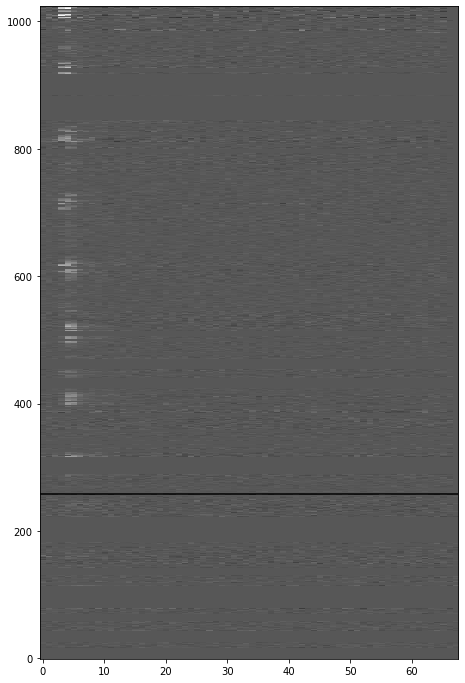

In [67]:
plt.figure(figsize=(7.5, 12))
plt.imshow(bursts[1], aspect='auto', origin='lower', cmap='gray')

# plt.axhline(y=145, c='k')
# plt.axhline(y=221, c='k')
plt.axhline(y=258, c='k')
# plt.axhline(y=311, c='k')
# plt.axhline(y=478, c='k')
# plt.axhline(y=512, c='k')
# plt.axhline(y=970, c='k')
# plt.axhline(y=1007, c='k')

bursts[1].shape

finding fit CHIME1...
solution nlsq: [  41.74851558   40.46235013 1023.40501795  176.24653795    2.20077067
    1.57187798]
parameter 1sigma: [2.02514459e-01 1.07153282e-02 8.54906032e-01 8.54906532e-01
 1.06753577e-02 8.56752638e-05]
plotting [  41.74851558   40.46235013 1023.40501795  176.24653795    2.20077067
    1.57187798]
finding fit CHIME2...
solution nlsq: [  36.15779297   68.39360871 1002.51224866  355.78768449    1.37681316
    1.57194437]
parameter 1sigma: [3.02751425e-02 1.20176051e-03 2.97825674e-01 2.98819811e-01
 1.15208839e-03 4.58145097e-06]
plotting [  36.15779297   68.39360871 1002.51224866  355.78768449    1.37681316
    1.57194437]
finding fit B1...
solution nlsq: [434.95457039 188.49880418 256.54932653 111.76830281  12.41175489
   1.56615762]
parameter 1sigma: [3.36705256e-02 9.54911558e-04 8.65183329e-03 8.95566208e-03
 9.54078656e-04 1.23086762e-05]
plotting [434.95457039 188.49880418 256.54932653 111.76830281  12.41175489
   1.56615762]
finding fit B2...
solut

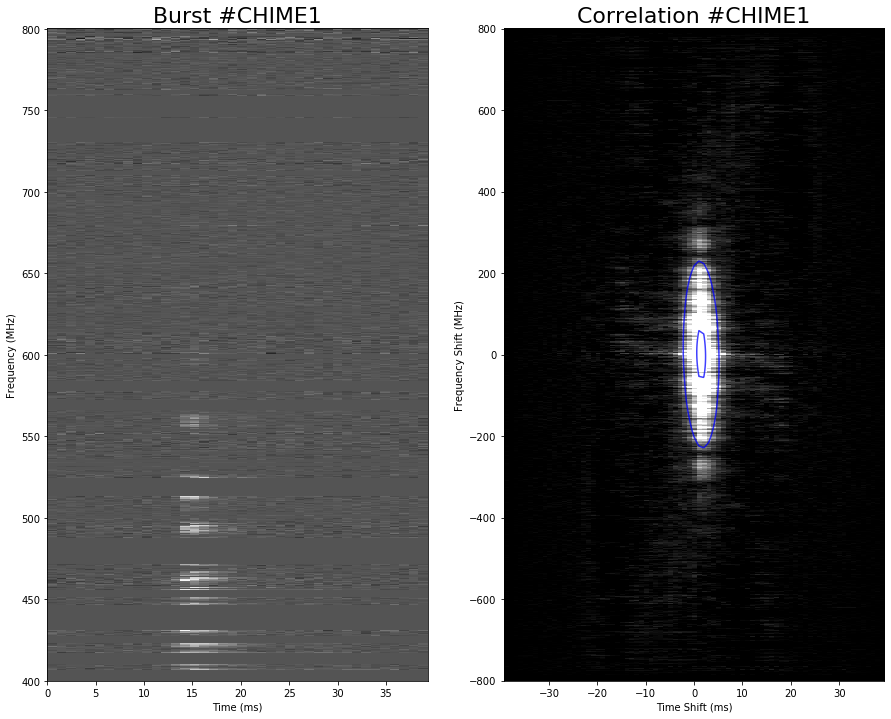

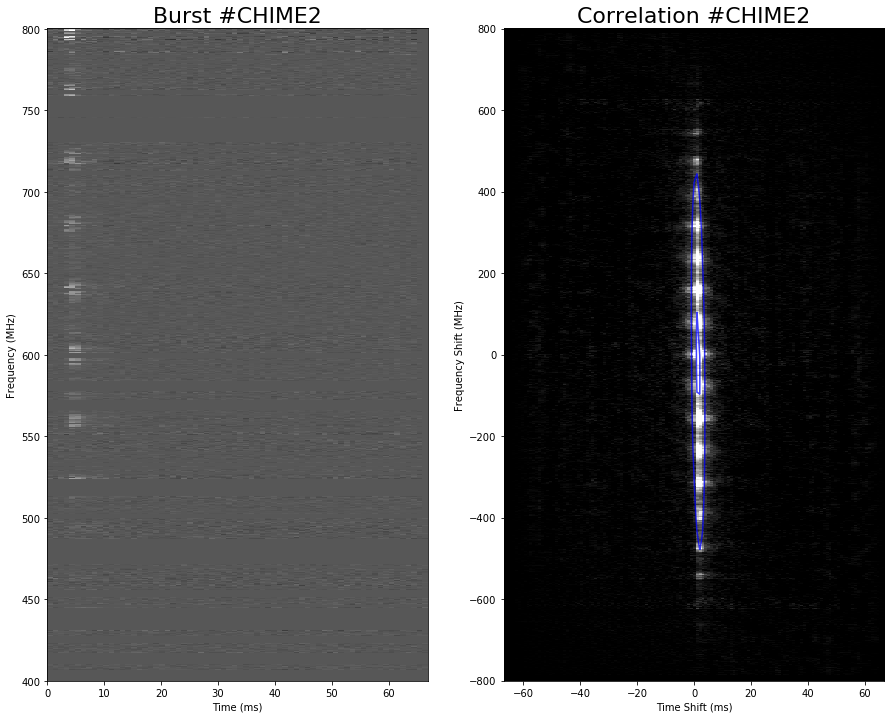

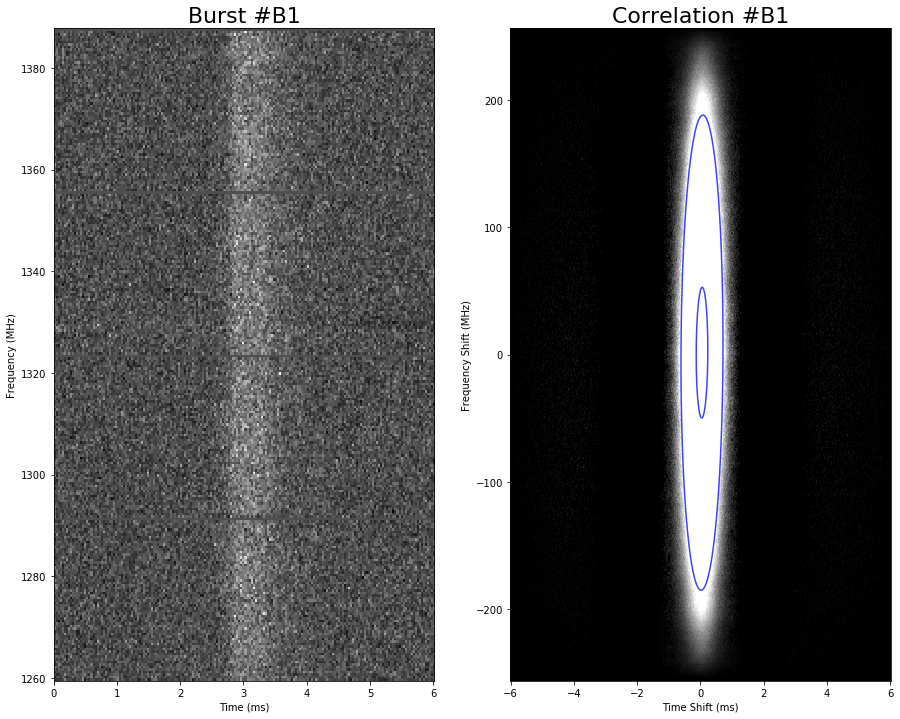

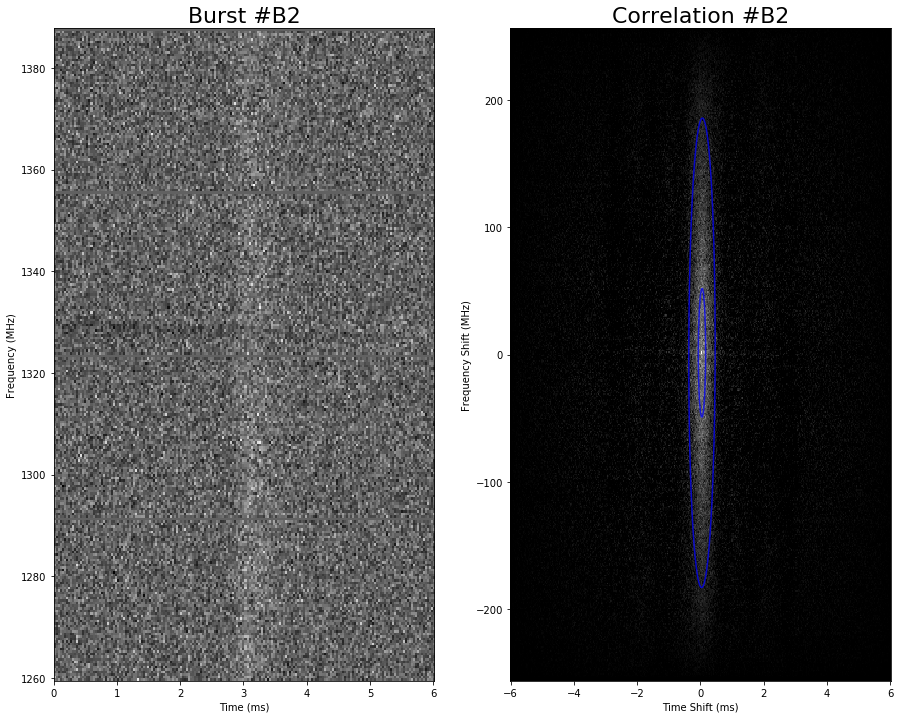

In [71]:
bursts = getCHIMEBurst() + getKirstenBursts()
# bursts = bursts[:2]

# CHIME1 Masking
bursts[0][221:224] = 0
bursts[0][257:259] = 0
bursts[0][312:318] = 0
bursts[0][144:146] = 0
bursts[0][114:116] = 0

# CHIME2 Masking
bursts[1][144:146] = 0
bursts[1][220:222] = 0
bursts[1][256:260] = 0
bursts[1][309:313] = 0
bursts[1][476:480] = 0
bursts[1][511:514] = 0
bursts[1][969:971] = 0
bursts[1][1006:1008] = 0

drifts = []
for burst, bid, p0 in zip(bursts, 
                          ['CHIME1', 'CHIME2', 'B1', 'B2'], 
                          [[1000, 40, 1024, 50, 10, 1.567], [41, 68, 1023, 176, 2, 1.57], [], []]):

    if bid[0] == 'C':
        params = CHIMEParameters
    elif bid[0] == 'A':
        params = AROParameters
    elif bid[0] == 'B':
        params = KirstenParameters

    if bid == 'ARO2':
        print(driftrate.processBurst(burst, bid, params['df_mhz'], params['dt_s']*1000, params['freq_bottom_mhz'], clip=4))
    else:
        drift, drift_error, popt, perr, theta, red_chisq, center_f = driftrate.processBurst(burst, bid, params['df_mhz'], params['dt_s']*1000, params['freq_bottom_mhz'], p0=p0)
        drifts.append(drift)

# print(drifts)
print(drifts)
## Todo: STARE2